# Projet Analyse de Données : Formule 1

<b>Ce projet porte sur l'étude et l'analyse des résultats et de données de toutes les courses de Formule 1 qui se sont déroulées de 1950 à 2018.</b><br><br>
En Formule 1, de nombreux facteurs sont clés dans la route vers la victoire d'un Grand Prix. On retrouve entre autres : 
<ul>
    <li>La performance de la voiture</li>
    <li>Le talent du pilote</li>
    <li>La position sur la grille (déterminée par une séance de qualification)</li>
    <li>La gestion de l'essence</li>
    <li>La gestion de l'usure des pneus et l'utilisation astucieuse d'arrêts au stand</li>
    <li>La réactivité aux évènements de course comme la tombée de pluie, les accidents sur piste...</li>
</ul>

Dans ce projet, nous allons: 

<ul>
    <li>1. tenter de prédire la position à l'arrivée d'un pilote  </li>
    <li>2. essayer de déterminer à quel moment de la course un pilote a réalisé un arrêt au stand</li>
    <li>3. le type de pneus utilsé dans chaque tour</li>

</ul>
<br><br>


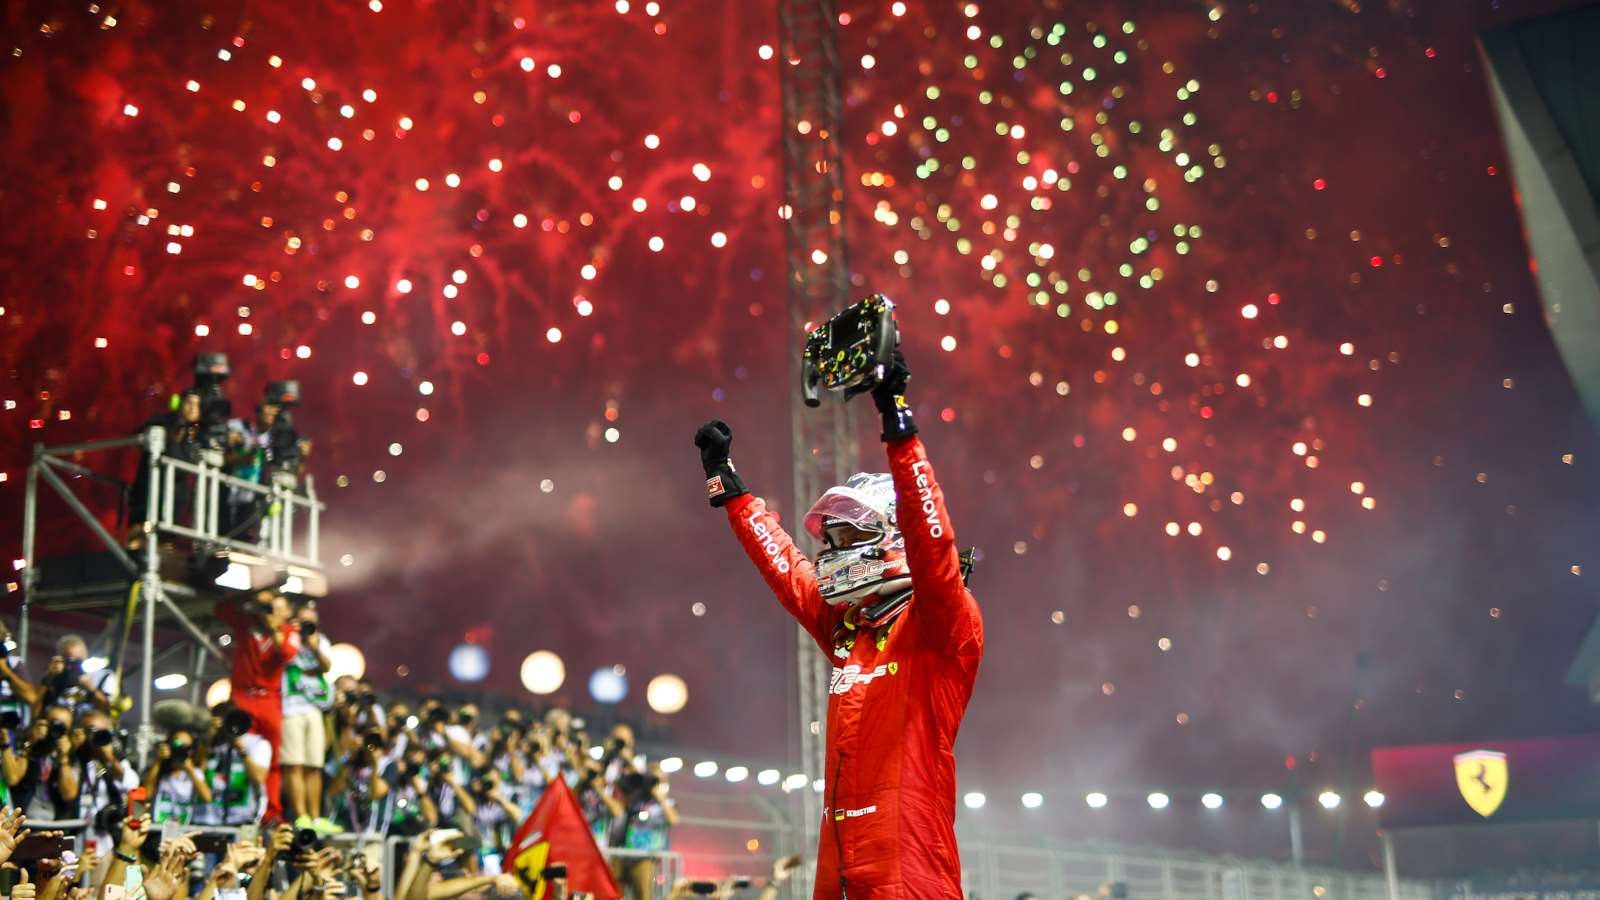


## 1. Prédiction de la position  à l'arrivée d'un pilote

On importe les librairies utiles pour ce projet.

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from mpl_toolkits import mplot3d #Graphique 3D
from mpl_toolkits.mplot3d import axes3d


warnings.filterwarnings("ignore") #On n'affiche pas les avertissements
sns.set()
sns.set_style("white")


mpl.rcParams['figure.figsize'] = (12, 10)

On importe les datasets

In [3]:
circuits = pd.read_csv("datasets/circuits.csv", index_col=0)
constructorResults = pd.read_csv("datasets/constructor_results.csv", index_col=0)
constructors = pd.read_csv("datasets/constructors.csv", index_col=0)
constructorStandings = pd.read_csv("datasets/constructor_standings.csv", index_col=0)
drivers = pd.read_csv("datasets/drivers.csv", index_col=0)
lapTimes = pd.read_csv("datasets/lap_times.csv")
pitStops = pd.read_csv("datasets/pit_stops.csv")
qualifying = pd.read_csv("datasets/qualifying.csv", index_col=0)
races = pd.read_csv("datasets/races.csv",index_col=0)
results = pd.read_csv("datasets/results.csv", index_col=0)
status = pd.read_csv("datasets/status.csv", index_col=0)
races = races.reindex(np.random.permutation(races.index))

Ici, nous allons supprimer les colonnes qui ne nous intéressent pas et qui prennent une place inutile à l'affichage.<br>

In [4]:
drivers = drivers.drop(columns='url')
circuits = circuits.drop(columns=['alt','url','lat','lng','location'])
constructorResults = constructorResults.drop(columns='status')
constructors = constructors.drop(columns=['url'])
races = races.drop(columns=['url','time'])
# races.index.name = 'raceId'

On choisit uniquement les colonnes utiles pour la prédiction

In [5]:
data = results[["raceId","driverId","constructorId","grid","position","statusId"]]
data.head()

,raceId,driverId,constructorId,grid,position,statusId
resultId,,,,,,
1,18,1,1,1,1,1
2,18,2,2,5,2,1
3,18,3,3,7,3,1
4,18,4,4,11,4,1
5,18,5,1,3,5,1


Le dataset ne nous fournit pas la puissance de la voiture, cette donnée n'étant pas quantifiable (mis à part peut-être la puissance du moteur). Nous devons donc essayer nous-même de quantifier ce paramètre.

Dans le paddock, les deux ou trois écuries dominatrices arrivent à réaliser des tours souvent plus d'une seconde plus rapide que les écuries de milieu de plateau et les <i>backmarkers</i> : on cherche donc un coefficient $\mu_x$ permettant de modéliser cette disparité. Nous choisirons $\mu_x = \frac{1}{tan(0.1x)^{0.7}}$, avec $x$ la position au championnat constructeurs de l'année précédente nous appellerons cette feature **"constructorPower"**.

Bien entendu, les avancées technologiques d'une écurie ne se conservent pas toujours d'une année sur l'autre : un exemple flagrant en est l'écurie Brawn GP, victorieuse en 2009 grâce à un système à la légalité douteuse mais seulement 4e en 2010, sous l'égide de son acquéreur Mercedes. Ainsi, on utilise un deuxième coefficient, que nous appellerons coefficient de forme **"constructorForm"**, qui reprend l'équation du coefficient de puissance en remplacant $x$ par la position actuelle au championnat constructeur : ce coefficient progresse donc au fur et à mesure de la saison.

[Text(0,0.5,'Coefficient de puissance'),
 Text(0.5,0,'Position au championnat n-1')]

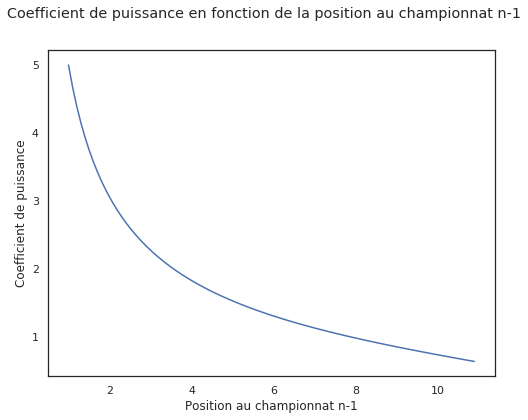

In [6]:
x = np.arange(1,11,0.1)
y = 1.0/np.power(np.tan(0.1*x),0.7)
fig = plt.figure(figsize=(8,6))
fig.suptitle("Coefficient de puissance en fonction de la position au championnat n-1")
ax = sns.lineplot(x, y )
ax.set(xlabel='Position au championnat n-1', ylabel='Coefficient de puissance')

[Text(0,0.5,'Coefficient de forme'), Text(0.5,0,'Avancee de la saison')]

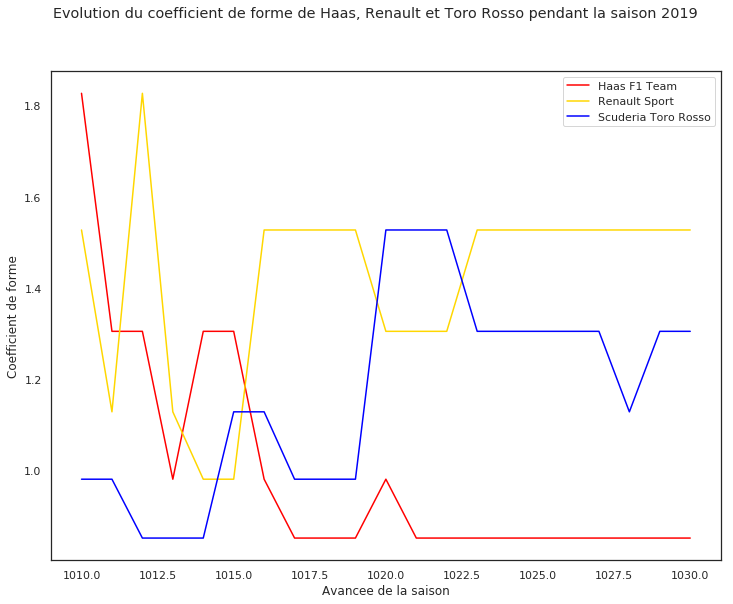

In [7]:
#Evolution du coefficient de forme de Renault pendant la saison 2019
myraces = constructorStandings[(constructorStandings['raceId'] >= 1010) & (constructorStandings['raceId'] <= 1034)]
myraces['constructorForm']  = pd.Series(myraces["position"].apply(lambda x: 1.0/np.power(np.tan(0.1*x),0.7)))
myracesHaas = myraces[myraces['constructorId'] == 210]
myracesRenault = myraces[myraces['constructorId'] == 4]
myracesSTR = myraces[myraces['constructorId'] == 5]
fig = plt.figure(figsize=(12,9))
fig.suptitle("Evolution du coefficient de forme de Haas, Renault et Toro Rosso pendant la saison 2019")

ax = sns.lineplot(myracesHaas['raceId'], myracesHaas['constructorForm'], color='red', legend='brief', label='Haas F1 Team')
ax2 = sns.lineplot(myracesRenault['raceId'], myracesRenault['constructorForm'], color='gold', legend='brief', label='Renault Sport')
ax2 = sns.lineplot(myracesSTR['raceId'], myracesSTR['constructorForm'], color='blue', legend='brief', label='Scuderia Toro Rosso')
ax.set_facecolor('xkcd:white')
ax.set(xlabel='Avancee de la saison', ylabel='Coefficient de forme')

In [8]:
# pour calculer "constructorForm " 
constructorStandings['constructorForm']  = pd.Series(constructorStandings["position"].apply(lambda x: 1.0/np.power(np.tan(0.1*x),0.7)))
constructorinfo = constructorStandings.drop(['points','position','positionText','wins'],axis=1)


In [9]:
data = pd.merge(data,constructorinfo,on=['raceId','constructorId'])
data.head()

,raceId,driverId,constructorId,grid,position,statusId,constructorForm
0,18,1,1,1,1,1,5.000164
1,18,5,1,3,5,1,5.000164
2,18,2,2,5,2,1,2.273518
3,18,9,2,2,\N,4,2.273518
4,18,3,3,7,3,1,3.056239


calculer **constructorPower** : 

In [10]:
# pour calculer le classment de chaque equipe a lafin de la saison 

merged = constructorStandings.merge(races,right_index=True,left_on='raceId')
endOfYearPOS = merged.loc[merged.groupby(['year',"constructorId"])['round'].idxmax(),["position","constructorId","year"]]
endOfYearPOS.rename(columns={'position':'endYearPos'},inplace=True)
merged2  = pd.merge(merged,endOfYearPOS,on=['year',"constructorId"])
merged2.drop(['position','positionText','circuitId','wins','round','name','date'],axis=1,inplace=True)

merged2

,raceId,constructorId,points,constructorForm,year,endYearPos
0,18,1,14.0,5.000164,2008,2
1,19,1,24.0,5.000164,2008,2
2,20,1,28.0,2.273518,2008,2
3,21,1,34.0,2.273518,2008,2
4,22,1,42.0,2.273518,2008,2
5,23,1,53.0,3.056239,2008,2
6,24,1,53.0,2.273518,2008,2
7,25,1,58.0,2.273518,2008,2
8,26,1,72.0,2.273518,2008,2
9,27,1,86.0,2.273518,2008,2


In [11]:
# pour avoir le classment final de l'an dernier de chaque equipe 
#%%time
c = merged2.copy()
def lastyearPOS(x):
    try:
        x.endYearPos = c['endYearPos'][c['constructorId']==x.constructorId][c['year']==(x.year-1)].tolist()[0]  
        return x  
    except Exception:
        x.endYearPos=5
        return x
merged2 = merged2.apply(lastyearPOS,axis=1)
del c
print("fini")

fini


In [12]:
merged2['constructorPower'] = merged2["endYearPos"].apply(lambda x: 1.0/np.power(np.tan(0.1*x),0.7))

In [13]:
merged2.drop(['constructorForm','endYearPos','points'],axis=1,inplace=True)

In [14]:
#merged2[merged2['constructorId']==1][merged2['year']==2019]
data = data.merge(merged2,on=['raceId','constructorId'])
data.rename(columns={'position':'positionOrder','constructorpower':'constructorPower'},inplace=True)
data.head()


,raceId,driverId,constructorId,grid,positionOrder,statusId,constructorForm,year,constructorPower
0,18,1,1,1,1,1,5.000164,2008.0,0.623280
1,18,5,1,3,5,1,5.000164,2008.0,0.623280
2,18,2,2,5,2,1,2.273518,2008.0,3.056239
3,18,9,2,2,\N,4,2.273518,2008.0,3.056239
4,18,3,3,7,3,1,3.056239,2008.0,1.826882


La performance d'un pilote est également, à première vue, une donnée très importante pour bien réussir la prédiction. Similairement au cas des coefficients de forme et de performance, nous ne disposons pas d'une colonne dans le dataset nous indiquant directement le niveau d'un pilote. Nous allons ainsi extraire cette information avec les données dont on dispose : <br>
Pour un pilote $i$, on crée le coefficient de performance $\mu_i$ de la manière suivante : $\mu_i = \frac{1}{1 + \exp^{((x_j - x_i) + (r_j - r_i))}}$ avec

- $x_i$ la position moyenne de qualifications du pilote
- $x_j$ la position moyenne de qualifications de son équipier
- $r_i$ le résultat de course moyen du pilote
- $r_j$ le résultat de course moyen de son équipier


In [15]:
def getTeammate(raceId,driverId):
    result = results[results['raceId'] == raceId]
    constructor = result[result['driverId'] == driverId]['constructorId'].iloc[0]
    current_round = races['round'].loc[raceId]
    try:
        teammate = result[(results['constructorId'] == constructor) & (results['driverId'] != driverId)]['driverId'].iloc[0]
    except Exception:
        if current_round > 1: #Si ce n'est pas la première course de la saison, on retourne l'équipier de la course précédente
            return getTeammate(raceId-1, driverId)
        else:
            return getTeammate(raceId+1, driverId)
    return teammate
    
def getAverageQualifyingPosition(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : Le résultat moyen en qualifications pour cette saison (float)
    '''
    year = races['year'].loc[raceId]
    current_round = races['round'].loc[raceId]
    quali = 0
    nbMissing = 0
    for i in range(1,current_round+1):
        myrace = races[(races['year'] == year) & (races['round'] == i)].index[0]
        try:
            quali += qualifying[(qualifying['raceId'] == myrace) & (qualifying['driverId'] == driverId)]['position'].iloc[0]
        except Exception: #Si un pilote n'a pas participé à une séance de qualifications
            nbMissing +=1
    quali /= 1.0*(current_round-nbMissing)
    return quali

def getAverageFinalPosition(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : Le résultat moyen en course pour cette saison (float)
    '''
    year = races['year'].loc[raceId]
    current_round = races['round'].loc[raceId]
    pos = 0
    nbMissing = 0
    for i in range(1,current_round+1):
        try:
            myrace = races[(races['year'] == year) & (races['round'] == i)].index[0]
            #print("{}, {}\r".format(myrace, driverId)),
            pos += results[(results['raceId'] == myrace) & (results['driverId'] == driverId)]['positionOrder'].iloc[0]
        except Exception:
            nbMissing +=1
    pos /= 1.0*(current_round-nbMissing)
    return pos

def getDriverName(driverId):
    '''
    In : driverId (int) : numéro d'identification du pilote
    Out : nom et prénom du pilote (string)
    '''
    try:
        name = str(drivers['forename'].loc[driverId])+' '+str(drivers['surname'].loc[driverId])
        return name
    except UnicodeDecodeError:
        return driverRef


In [16]:
def computeDriverPerformance(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : Le coefficient de performance du pilote pour la saison en cours (float)
    '''
    try : 
        print("Id du pilote : {}, Id de la course : {} \r".format(driverId, raceId)),
        teammate = getTeammate(raceId, driverId)
        avg_quali_pos = getAverageQualifyingPosition(raceId, driverId)
        teammate_quali_pos = getAverageQualifyingPosition(raceId, teammate)
        avg_final_pos = getAverageFinalPosition(raceId, driverId)
        teammate_final_pos = getAverageFinalPosition(raceId, teammate)
        #quali_h2h = getQualiHeadToHead(raceId,driverId)
        #race_h2h = getRaceHeadToHead(raceId,driverId)
        coefficient = (teammate_quali_pos-avg_quali_pos) + (teammate_final_pos-avg_final_pos)
#         coefficient = np.power(1.1,coefficient)
        coefficient = 1./(1+np.exp(-coefficient))
    except Exception:
       return 1.0 # on cas où un pilote n'as pas de teammate ou n'as pas participé au qualification on lui donne la valeur de la median de ce coefficient
    return coefficient

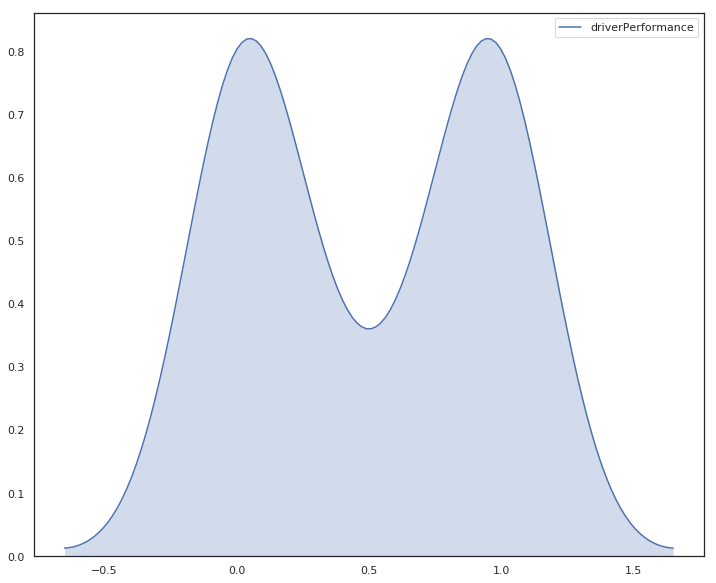

In [17]:
test = data.iloc[0:50]
test['driverPerformance'] = test.apply(lambda x: computeDriverPerformance(x['raceId'], x['driverId']), axis=1)
sns.kdeplot(test['driverPerformance'], shade=True)

In [18]:
# calcul de driverPerformance
'''
CETTE FONCTION PREND UN TEMPS FOU A EXECUTER
PROCEED WITH CAUTION
'''
#%time data['driverPerformance'] = results.apply(lambda x: computeDriverPerformance(x['raceId'], x['driverId']), axis=1) 


'\nCETTE FONCTION PREND UN TEMPS FOU A EXECUTER\nPROCEED WITH CAUTION\n'

In [21]:
# data.to_csv('final_dataset_2.csv')
# data.describe()

In [22]:
mydata = 0

In [23]:
mydata = pd.read_csv('final_dataset.csv')
res_cropped = results[['raceId', 'driverId', 'positionOrder']]
mydata = mydata.merge(res_cropped, on=['raceId', 'driverId'])
display(mydata.head(10))
display(mydata.describe())

,Unnamed: 0,raceId,driverId,constructorId,grid,positionOrder_x,statusId,year,constructorPower,constructorForm,driverPerformance,positionOrder_y
0,0,18,1,1,1,1,1,2008.0,0.623280,5.000164,1.771561,1
1,1,18,5,1,3,5,1,2008.0,0.623280,5.000164,1.464100,5
2,2,18,2,2,5,2,1,2008.0,3.056239,2.273518,2.593742,2
3,3,18,9,2,2,\N,4,2008.0,3.056239,2.273518,5.054470,9
4,4,18,3,3,7,3,1,2008.0,1.826882,3.056239,0.564474,3
5,5,18,6,3,13,6,11,2008.0,1.826882,3.056239,0.385543,6
6,6,18,4,4,11,4,1,2008.0,2.273518,1.826882,1.610510,4
7,7,18,12,4,20,\N,8,2008.0,2.273518,1.826882,0.513158,12
8,8,18,7,5,17,7,5,2008.0,1.127658,1.526851,0.683013,7
9,9,18,20,5,9,\N,4,2008.0,1.127658,1.526851,1.210000,20


,Unnamed: 0,raceId,driverId,constructorId,grid,statusId,year,constructorPower,constructorForm,driverPerformance,positionOrder_y
count,22762.000000,22762.000000,22762.000000,22762.000000,22762.000000,22762.000000,22762.000000,22184.000000,22119.000000,9164.000000,22762.000000
mean,11376.445260,485.638564,215.248440,43.075652,11.121430,17.527151,1991.192382,1.778287,1.755547,1.166385,12.957122
std,6565.771929,279.319362,234.417431,56.261290,7.219184,25.746511,16.582689,1.206822,1.295749,0.841986,7.749613
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1958.000000,0.156861,0.156861,0.035584,1.000000
25%,5690.250000,269.000000,49.000000,6.000000,5.000000,1.000000,1978.000000,0.979762,0.850555,0.765774,6.000000
50%,11380.500000,467.000000,140.000000,22.000000,11.000000,11.000000,1991.000000,1.526851,1.304367,1.000000,12.000000
75%,17068.750000,689.000000,278.000000,50.000000,17.000000,14.000000,2006.000000,2.273518,2.273518,1.305869,19.000000
max,22744.000000,1030.000000,848.000000,211.000000,32.000000,137.000000,2019.000000,5.000164,5.000164,28.102437,39.000000


In [24]:
##### # my_dataset = pd.read_csv('final_dataset_2.csv')
my_dataset = mydata
#my_dataset.describe()
'''
On garde uniquement les pilotes qui ont terminé la course
Status 1 : fini la course
Status 11 : +1 Lap
Status 12 : +2 Laps
'''
my_dataset = my_dataset[(my_dataset['statusId'] == 1) | (my_dataset['statusId'] == 11) | (my_dataset['statusId'] == 12)]
# my_dataset["positionOrder"] = my_dataset["positionOrder"].astype('int64')
my_dataset = my_dataset.rename(columns={"positionOrder_y":"positionOrder"})
my_dataset["driverPerformance"] = my_dataset['driverPerformance'].apply(lambda x: 1./(1 + np.exp(-x)))
# my_dataset["driverPerformance"] = my_dataset['driverPerformance'].apply(lambda x: -np.log((1./x) - 1))
#On garde uniquement les colonnes qui nous intéressent.
my_dataset = my_dataset[['grid','positionOrder','constructorForm','driverPerformance']]
#On mélange le dataset
my_dataset = my_dataset.reindex(np.random.permutation(my_dataset.index))
my_dataset = my_dataset.dropna()
my_dataset = my_dataset[(np.abs(my_dataset['driverPerformance']) < 10)]
my_dataset.describe()

,grid,positionOrder,constructorForm,driverPerformance
count,5474.000000,5474.000000,5474.000000,5474.000000
mean,10.025027,7.607234,2.038976,0.741407
std,6.099090,4.592663,1.345293,0.091684
min,0.000000,1.000000,0.156861,0.508895
25%,5.000000,4.000000,0.979762,0.681230
50%,10.000000,7.000000,1.526851,0.731059
75%,15.000000,11.000000,2.273518,0.791006
max,26.000000,22.000000,5.000164,1.000000


Traçons quelques graphiques pour visualiser la distribution de nos données.

- Sur le premier graphique, on voit qu'il y a une très forte corrélation entre la position sur la grille et la position à l'arrivée.

- Sur les deuxième et troisième graphes, on remarque la corrélation entre les coefficients de puissance et de forme et la position à l'arrivée.

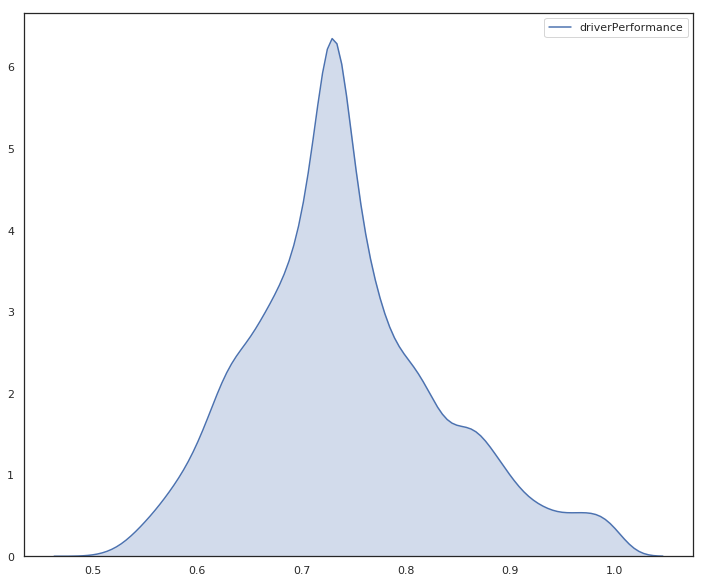

In [25]:
sns.kdeplot(my_dataset['driverPerformance'], shade=True)

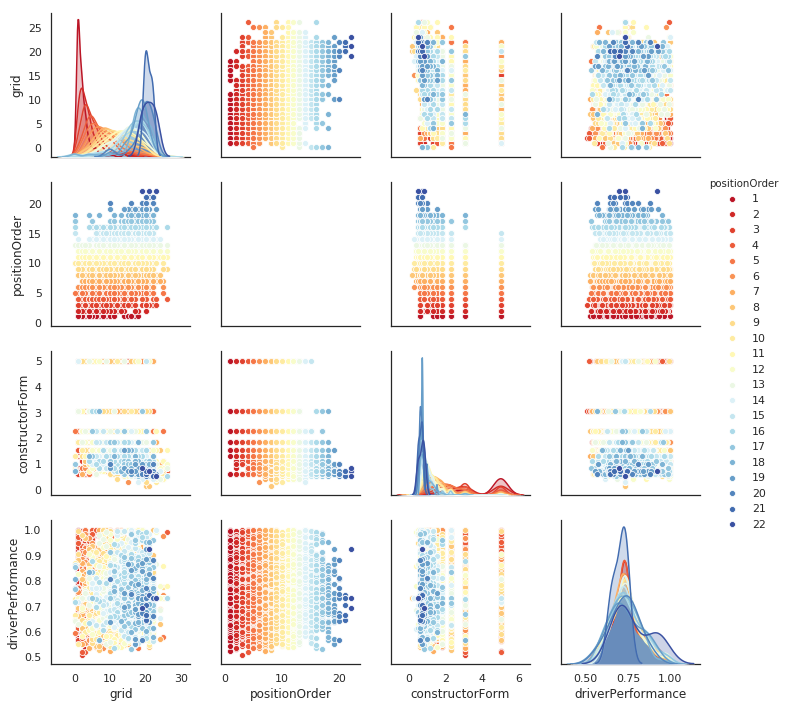

In [26]:
sns.pairplot(my_dataset, hue="positionOrder", palette='RdYlBu');

Text(0.5,0.98,"Position a l'arrivee en fonction de la performance du pilote")

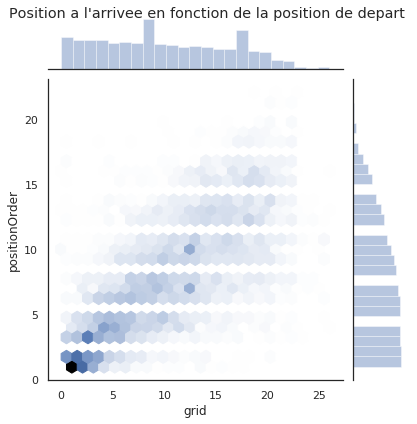

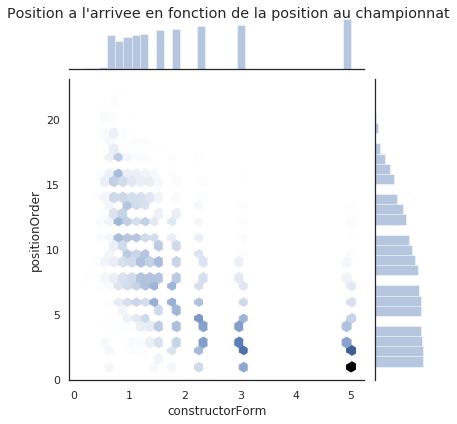

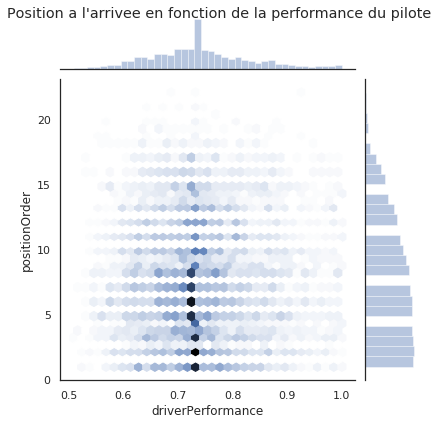

In [27]:
sns.jointplot(my_dataset['grid'],my_dataset['positionOrder'],
              kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la position de depart")

# sns.jointplot(my_dataset['constructorPower'],my_dataset['positionOrder'],
#               kind='hex')
# plt.suptitle("Position a l'arrivee en fonction de la position au championnat n-1")

sns.jointplot(my_dataset['constructorForm'],my_dataset['positionOrder'],
              kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la position au championnat")
sns.jointplot(my_dataset['driverPerformance'],my_dataset['positionOrder'], kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la performance du pilote")

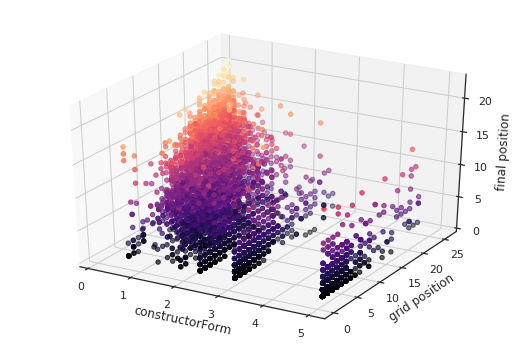

In [28]:
#matplotlib notebook pour faire tourner le graphique
%matplotlib inline
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111, projection='3d')
# Data for three-dimensional scattered points
zdata1 = my_dataset['positionOrder']
xdata1 = my_dataset['constructorForm']
ydata1 = my_dataset['grid']
ax1.scatter3D(xdata1, ydata1, zdata1, c=(zdata1), cmap='magma');
ax1.set_xlabel('constructorForm')
ax1.set_ylabel('grid position')
ax1.set_zlabel('final position')
fig.show()

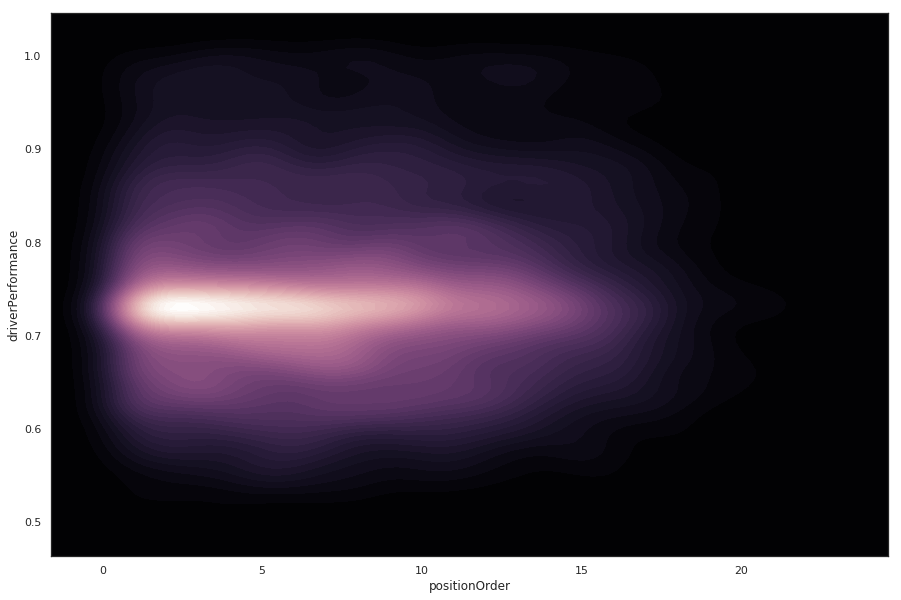

In [29]:
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(my_dataset['positionOrder'],my_dataset['driverPerformance'], cmap=cmap, n_levels=60, shade=True);

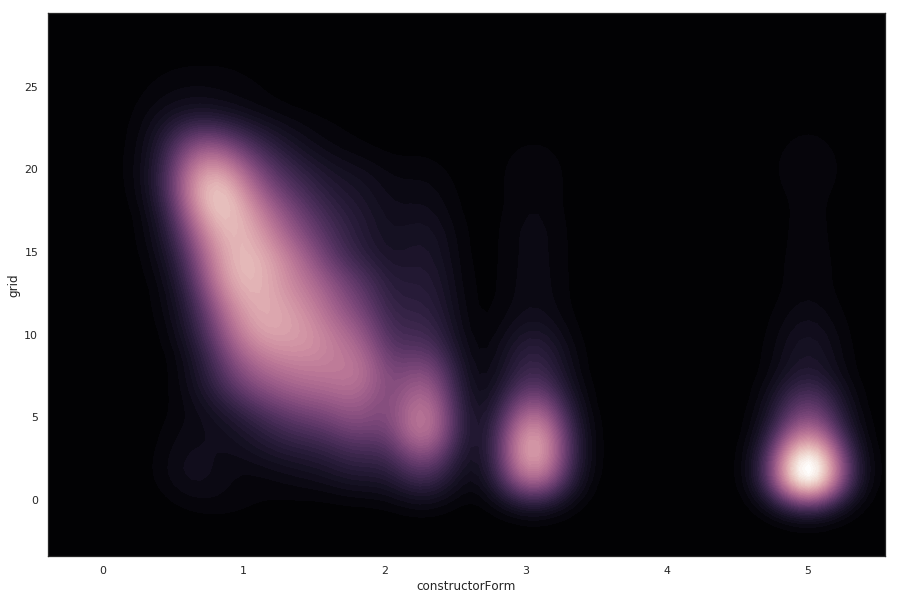

In [30]:
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(my_dataset['constructorForm'],my_dataset['grid'], cmap=cmap, n_levels=60, shade=True);

In [31]:
#Afin d'être sûrs, on retire les valeurs nulles
my_dataset = my_dataset.dropna()

#On crée les ensembles d'entraînement et de test.
train_dataset = my_dataset.sample(frac=0.8,random_state=1)
test_dataset = my_dataset.drop(train_dataset.index)

#C'est une manière de récupérer la moyenne et l'écart-type de chaque colonne.
train_stats = train_dataset.describe()
train_stats.pop("positionOrder")
train_stats = train_stats.transpose()

train_labels = train_dataset.pop('positionOrder')
test_labels = test_dataset.pop('positionOrder')

def stand(x): # fonction pour standaridiser les données
    return (x - train_stats['mean']) / train_stats['std']
std_train_data = stand(train_dataset)
std_test_data = stand(test_dataset)

display(std_test_data.head(20))

,grid,constructorForm,driverPerformance
336,1.635990,-0.974549,0.893904
20867,-1.485507,2.208851,1.566706
20812,1.471701,-0.790713,-0.496166
20352,0.321675,-0.382538,-0.110648
22399,1.143122,-0.974549,0.027454
3039,1.471701,-0.790713,-0.967755
472,1.471701,-0.158689,0.184288
4207,0.485965,-0.680370,0.249799
61,-0.171193,0.758517,-0.887286
5278,1.635990,-0.974549,-1.743770


### Création d'un réseau de neurones avec TensorFlow

Typiquement, TensorFlow permet d'obtenir une bonne précision sur les résultats si on sait ce qu'on fait.
Nous allons créer et entraîner ce réseau de neurone avec TensorFlow puis comparer ses prédictions avec notre modèle lineaire.

In [32]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()

In [33]:
EPOCHS = 100

history = model.fit(
  std_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)
test_predictions = model.predict(std_test_data).flatten()


Train on 3503 samples, validate on 876 samples
Epoch 1/100
3503/3503 [==============================] - 1s 314us/sample - loss: 21.2780 - mae: 3.4204 - mse: 21.2780 - val_loss: 10.1084 - val_mae: 2.4603 - val_mse: 10.1084
Epoch 2/100
3503/3503 [==============================] - 0s 115us/sample - loss: 9.8012 - mae: 2.4140 - mse: 9.8012 - val_loss: 8.8668 - val_mae: 2.3130 - val_mse: 8.8668
Epoch 3/100
3503/3503 [==============================] - 0s 114us/sample - loss: 9.2686 - mae: 2.3437 - mse: 9.2686 - val_loss: 8.6801 - val_mae: 2.3163 - val_mse: 8.6801
Epoch 4/100
3503/3503 [==============================] - 0s 109us/sample - loss: 9.1005 - mae: 2.3228 - mse: 9.1005 - val_loss: 8.6464 - val_mae: 2.2744 - val_mse: 8.6464
Epoch 5/100
3503/3503 [==============================] - 0s 114us/sample - loss: 9.0876 - mae: 2.3168 - mse: 9.0876 - val_loss: 8.3058 - val_mae: 2.2207 - val_mse: 8.3058
Epoch 6/100
3503/3503 [==============================] - 0s 122us/sample - loss: 8.9908 - mae:

3503/3503 [==============================] - 1s 392us/sample - loss: 8.6824 - mae: 2.2663 - mse: 8.6824 - val_loss: 8.0571 - val_mae: 2.2004 - val_mse: 8.0571
Epoch 49/100
3503/3503 [==============================] - 1s 360us/sample - loss: 8.6350 - mae: 2.2560 - mse: 8.6350 - val_loss: 8.4642 - val_mae: 2.2043 - val_mse: 8.4642
Epoch 50/100
3503/3503 [==============================] - 1s 370us/sample - loss: 8.6840 - mae: 2.2631 - mse: 8.6840 - val_loss: 8.4885 - val_mae: 2.2387 - val_mse: 8.4885
Epoch 51/100
3503/3503 [==============================] - 1s 384us/sample - loss: 8.7101 - mae: 2.2673 - mse: 8.7101 - val_loss: 7.9305 - val_mae: 2.1854 - val_mse: 7.9305
Epoch 52/100
3503/3503 [==============================] - 1s 376us/sample - loss: 8.6895 - mae: 2.2628 - mse: 8.6895 - val_loss: 8.3411 - val_mae: 2.2586 - val_mse: 8.3411
Epoch 53/100
3503/3503 [==============================] - 1s 373us/sample - loss: 8.6791 - mae: 2.2665 - mse: 8.6791 - val_loss: 8.0329 - val_mae: 2.1574

Epoch 96/100
3503/3503 [==============================] - 1s 383us/sample - loss: 8.5031 - mae: 2.2406 - mse: 8.5031 - val_loss: 7.8491 - val_mae: 2.1431 - val_mse: 7.8491
Epoch 97/100
3503/3503 [==============================] - 1s 365us/sample - loss: 8.5567 - mae: 2.2443 - mse: 8.5567 - val_loss: 8.0240 - val_mae: 2.1909 - val_mse: 8.0240
Epoch 98/100
3503/3503 [==============================] - 1s 362us/sample - loss: 8.5430 - mae: 2.2544 - mse: 8.5430 - val_loss: 8.3428 - val_mae: 2.1823 - val_mse: 8.3428
Epoch 99/100
3503/3503 [==============================] - 1s 377us/sample - loss: 8.5586 - mae: 2.2431 - mse: 8.5586 - val_loss: 7.8957 - val_mae: 2.1770 - val_mse: 7.8957
Epoch 100/100
3503/3503 [==============================] - 1s 377us/sample - loss: 8.4939 - mae: 2.2362 - mse: 8.4939 - val_loss: 8.1370 - val_mae: 2.2464 - val_mse: 8.1370


In [34]:
print(test_predictions.shape)

(1095,)


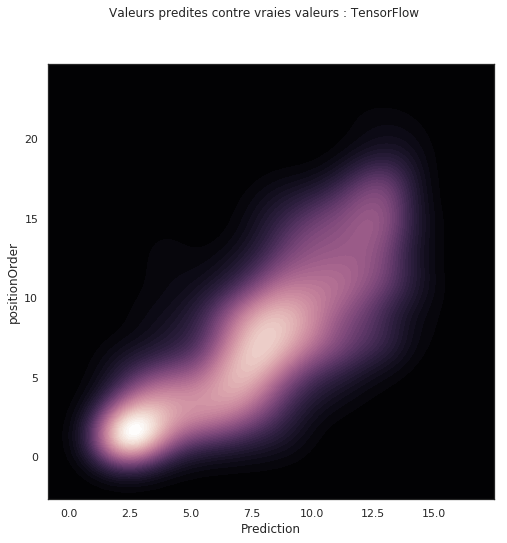

In [35]:
# sns.jointplot(test_labels, test_predictions, kind='hex')
# plt.suptitle('Valeurs predites par TensorFlow contre vraies valeurs')
f, ax = plt.subplots(figsize=(8, 8))
f.suptitle('Valeurs predites contre vraies valeurs : TensorFlow')
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
ax.set_xlabel('Prediction')
ax.set_ylabel('Realite')
sns.kdeplot(test_predictions,test_labels, cmap=cmap, n_levels=60, shade=True)

la RMSE de ce modèle est : 2.90457336793


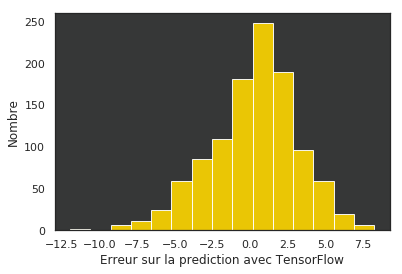

In [36]:
rmse_TF  = np.sqrt(np.square(test_predictions - test_labels).mean())
print('la RMSE de ce modèle est : {}'.format(rmse_TF))
TFError = test_predictions - test_labels
fig, ax = plt.subplots(1,1)
plt.hist(TFError, bins = 15, color='gold',alpha=0.9)
ax.set_facecolor('xkcd:dark grey')
ax.grid(False)

plt.xlabel("Erreur sur la prediction avec TensorFlow")
_ = plt.ylabel("Nombre")

Qu'observe-t-on ? On voit que la prédiction a fonctionné, l'algorithme arrive à trouver la position du pilote.

### Création du modèle lineaire

Ici, nous allons coder à la main un modèle de régression linéaire optimisé avec un algorithme de descente de gradient pour prédire la position à l'arrivée d'un pilote.
Ensuite, nous allons implémenter une solution d'optimisation directe en utilisant la formule suivante : $X^T\beta = Y \iff \beta = ((X^TX)^{-1}X^T)^{-1}Y$

In [37]:
from LinearModel import LinearModel  
# le code de LinearModel est dans le fichier LinearModel.py
hist = [] # loss pour chaque iteration
train = train_dataset.to_numpy()
lab = train_labels.to_numpy()
test = test_dataset.to_numpy()
test_lab = test_labels.to_numpy()
print(train.shape[1])

LM = LinearModel('RMSE')
hist = LM.build_model(train,lab,200)
predicted_labels = LM.predict(test)

3


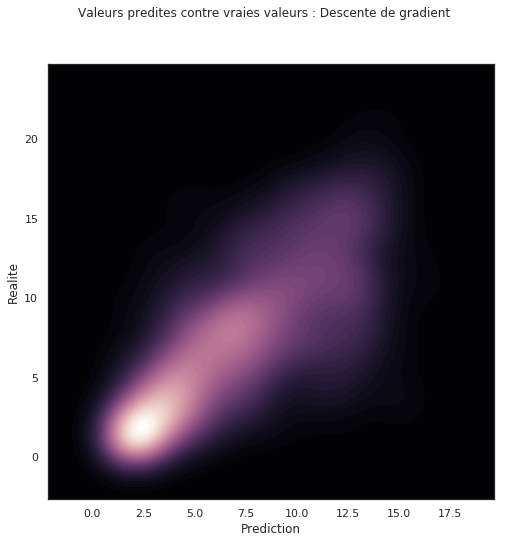

In [38]:
f, ax = plt.subplots(figsize=(8, 8))
f.suptitle('Valeurs predites contre vraies valeurs : Descente de gradient')
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
ax.set_xlabel('Prediction')
ax.set_ylabel('Realite')
sns.kdeplot(predicted_labels,test_lab, cmap=cmap, n_levels=60, shade=True)

Text(0.5,0.98,'Evolution de la RMSE en fonction des iterations')

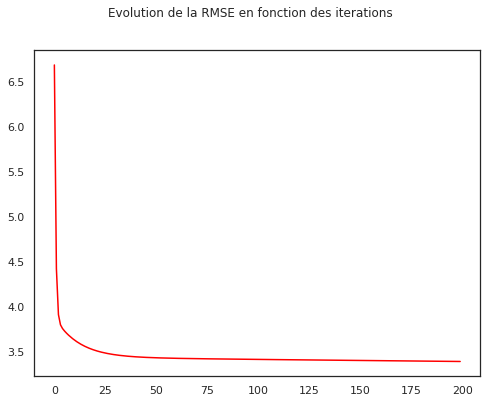

In [39]:
fig = plt.figure(figsize=(8,6))
ax3 = fig.add_subplot(111)
l1, = ax3.plot(np.arange(len(hist)), hist, 'red')
plt.suptitle('Evolution de la RMSE en fonction des iterations')

In [40]:
# Optimisation directe
train = train_dataset.to_numpy()
lab = train_labels.to_numpy()
test = test_dataset.to_numpy()
test_lab = test_labels.to_numpy()

def optimize(data,weights,labels,niter=100,speed=0.05,tol=0.00001,i=0):
    MM, MY = np.dot(np.transpose(data), data), np.dot(np.transpose(data), labels)
    return np.dot(np.linalg.inv(MM), MY)
def predict(data, weights):
    return np.dot(data,weights)
myweights = optimize(train, np.random.rand(train.shape[1]), lab)
mypreds = predict(test, myweights)

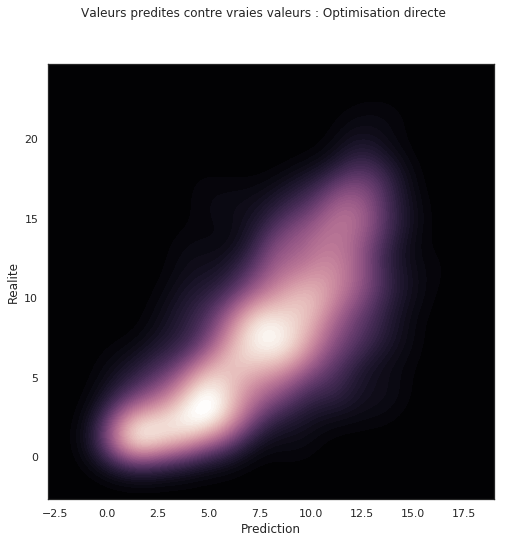

In [41]:
# myplot = sns.jointplot(mypreds, test_lab, kind='hex')
# plt.suptitle("Valeurs predites contre vraies valeurs")
f, ax = plt.subplots(figsize=(8, 8))
f.suptitle('Valeurs predites contre vraies valeurs : Optimisation directe')
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
ax.set_xlabel('Prediction')
ax.set_ylabel('Realite')
sns.kdeplot(mypreds,test_lab, cmap=cmap, n_levels=60, shade=True)

**Comparons les performances des différents algorithmes :**

Text(0.5,0,'Erreur sur la prediction')

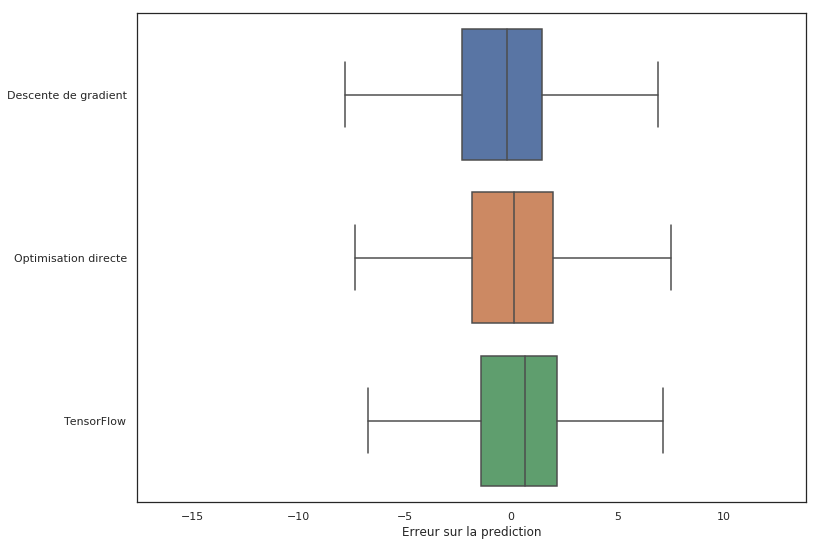

In [42]:
optimize_error = (mypreds - test_lab)
gradient_error = (predicted_labels - test_lab)
tensorflow_error = TFError
data = {'Optimisation directe':optimize_error, 'Descente de gradient':gradient_error, 'TensorFlow':tensorflow_error}
errors_df = pd.DataFrame(data)
fig = plt.figure(figsize=(12,9))
ax = sns.boxplot(orient="h", data=errors_df, fliersize=0)
ax.set_xlabel("Erreur sur la prediction")

In [43]:
print('La RMSE de la régression linéaire est {:.2f}'.format(hist[-1]))
print('La RMSE du réseau de neurones est {:.2f}'.format(rmse_TF))

La RMSE de la régression linéaire est 3.39
La RMSE du réseau de neurones est 2.90


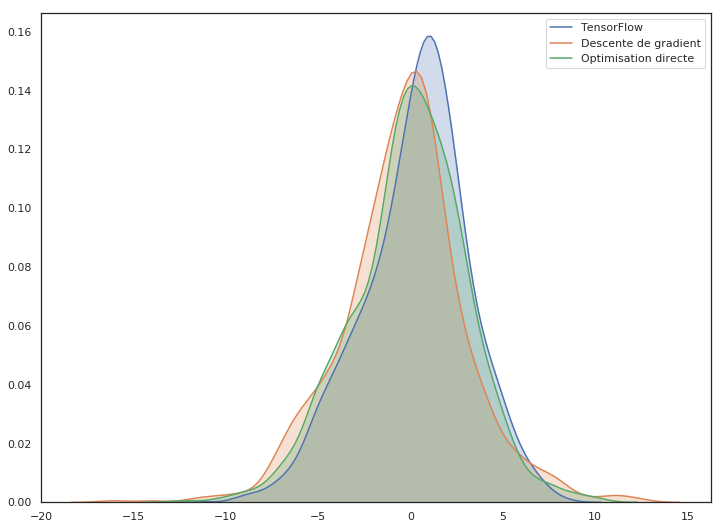

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
sns.kdeplot(TFError, shade=True, legend='brief', label='TensorFlow')
sns.kdeplot(gradient_error, shade=True, legend='brief', label='Descente de gradient')
sns.kdeplot(optimize_error, shade=True, legend='brief', label='Optimisation directe')
ax.grid(False)

On remarque que les trois algorithmes performent, sur l'ensemble de test, en moyenne de manière identique.

Le réseau de neurones est visiblement légèrement plus précis, mais les trois algorithmes restent comparables.

### Visualisation de nos algorithmes : une mise en situation

Nous avons tracé beaucoup de courbes et visualisé les erreurs moyennes, mais la manière la plus efficace de se rendre compte des performances de nos méthodes est de les appliquer à une situation réelle.

Testons nos algorithmes sur une course, comme par exemple Abu Dhabi 2017 (raceId = 998).

In [45]:
abudhabi = mydata[mydata['raceId'] == 988]
abudhabi = abudhabi.rename(columns={"positionOrder_y":"positionOrder"})
abudhabi["driverPerformance"] = abudhabi['driverPerformance'].apply(lambda x: 1./(1 + np.exp(-x)))
abudhabi = abudhabi[['grid','positionOrder','constructorForm','driverPerformance', 'driverId']]
abudhabi = abudhabi.dropna()
abudhabi.describe()
resultsAD = abudhabi.pop('positionOrder')
driversAD = abudhabi.pop('driverId')
abudhabi = abudhabi.to_numpy()

pred_tf = model.predict(abudhabi)
pred_tf = pred_tf.reshape(pred_tf.shape[0])
temp = np.flip(pred_tf.argsort())
ranks_tf = np.empty_like(temp)
ranks_tf[temp] = np.arange(1,len(pred_tf)+1)
# print(ranks_tf)


pred_opt = predict(data=abudhabi, weights=myweights)
temp = pred_opt.argsort()
ranks_opt = np.empty_like(temp)
ranks_opt[temp] = np.arange(1,len(pred_opt)+1)


pred_gd = LM.predict(data=abudhabi)
temp = pred_gd.argsort()
ranks_gd = np.empty_like(temp)
ranks_gd[temp] = np.arange(1,len(pred_gd)+1)


data = {"TensorFlow": ranks_tf, "Optimisation":ranks_opt, "Gradient":ranks_gd, "Resultat Final":resultsAD, "Pilote":driversAD}
df=pd.DataFrame(data)
df['Pilote'] = df['Pilote'].apply(lambda x:getDriverName(x))
df = df[['Pilote', 'Resultat Final', 'Optimisation', 'Gradient', 'TensorFlow']].sort_values('Resultat Final')
display(df)

,Pilote,Resultat Final,Optimisation,Gradient,TensorFlow
21901,Valtteri Bottas,1,1,1,6
21902,Lewis Hamilton,2,2,2,5
21903,Sebastian Vettel,3,4,3,1
21904,Kimi Räikkönen,4,3,5,2
21905,Max Verstappen,5,8,6,4
21907,Nico Hülkenberg,6,9,7,7
21909,Sergio Pérez,7,6,8,8
21910,Esteban Ocon,8,7,9,9
21911,Fernando Alonso,9,14,11,11
21913,Felipe Massa,10,11,10,10


On remarque que les algorithmes performent très raisonnablement ! 
Daniel Ricciardo et Carlos Sainz sont mal catégorisés car ils ont tous deux abandonné la course, une éventualité que le modèle ne prédit pas.